In [1]:
# Importing modules
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np

# use conda install pandas-datareader not pip install
import pandas_datareader as pdr

# pip install finpie==0.1
from finpie.economic_data import oecd_data
import quandl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Reading in the GDP data from FRED (St.Louis FED)
data_source = 'fred'
# Creating a range of dates - start and end
start = datetime.datetime (1960, 1, 1) 
end = datetime.datetime (2030, 12, 1)

#  U.S. GDP Seasonally Adjusted
gdp = pdr.DataReader('GDPC1', data_source, start, end)
# Renaming index
gdp.index.name = "Date"
# Renaming column
gdp.columns = ['gdp']
# Adding a YoY % change column
gdp['gdp_%yoy'] = gdp['gdp'].pct_change(4)
# Dropping the null(NaN) values
gdp.dropna(inplace=True)
# Rounding to 2 decimal places
gdp = gdp.round(4)

In [3]:
# Reading in the OECD CLI data (Monthly)- amplitude adjusted 
oecd = oecd_data.OecdData(country_code = 'USA', freq = 'M')
cli = pd.DataFrame(oecd.cli(subject = 'amplitude'))

In [4]:
# Dropping columns and renaming the index and the column `cli`
cli.drop(['SUBJECT', 'Subject', 
          'Country', 'FREQUENCY', 
          'TIME', 'Unit Code', 
          'PowerCode Code'], axis=1, inplace=True)

cli.index.name = "Date"
cli.columns = ['cli']

In [5]:
# Changing and checking that the `cli.index` was changed to a datetime format
cli.index = pd.to_datetime(cli.index)

# Will use this later for analyzing monthly data - `cli_monthly` DataFrame
cli_monthly = cli.copy()

type(cli.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [6]:
# Changing and checking that the `gdp.index` was changed to a datetime format
gdp.index = pd.to_datetime(gdp.index)
type(gdp.index)

pandas.core.indexes.datetimes.DatetimeIndex

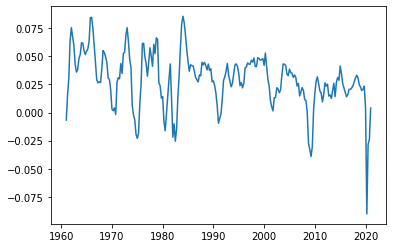

In [7]:
# A quick view at the GDP YoY % change chart
plt.plot(gdp.index, gdp['gdp_%yoy'])
plt.show()

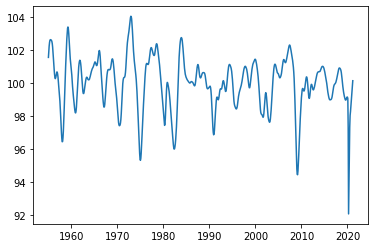

In [8]:
# A quick view at the CLI chart
plt.plot(cli.index, cli['cli'])
plt.show()

In [9]:
# Merging GDP and CLI data 
# Because GDP data is quartely the CLI data has changed from monthly to quarterly data after merging both dataframes
df = pd.merge(gdp, cli, left_index=True, right_index=True)
gdp_cli = df[['gdp_%yoy', 'cli']].copy()

In [10]:
gdp_cli.tail()

,gdp_%yoy,cli
Date,,
2020-01-01,0.0032,99.15754
2020-04-01,-0.0903,92.07619
2020-07-01,-0.0285,97.33352
2020-10-01,-0.0239,98.58372
2021-01-01,0.0040,99.52099


In [11]:
# Importing MinMaxScaler from scikit-learn to transmute the observed data 
from sklearn.preprocessing import MinMaxScaler

In [12]:
# Initializing MinMaxScaler using a range of -1 to 1 because data needs to oscilate around 0
scaler = MinMaxScaler(feature_range=(-1,1))
# Applying scaler to data
scaled_df = scaler.fit_transform(gdp_cli)

In [13]:
# Converting the array back to a DataFrame and using the same column headers and index header
normalized_df = pd.DataFrame(scaled_df, index=gdp_cli.index, columns = gdp_cli.columns)
# Rounding the DataFrame to 3 decimal places
normalized_df.round(3)

,gdp_%yoy,cli
Date,,
1961-01-01,-0.051,0.041
1961-04-01,0.203,0.224
1961-07-01,0.367,0.437
1961-10-01,0.752,0.548
1962-01-01,0.885,0.529
...,...,...
2020-01-01,0.062,0.184
2020-04-01,-1.000,-1.000
2020-07-01,-0.298,-0.121


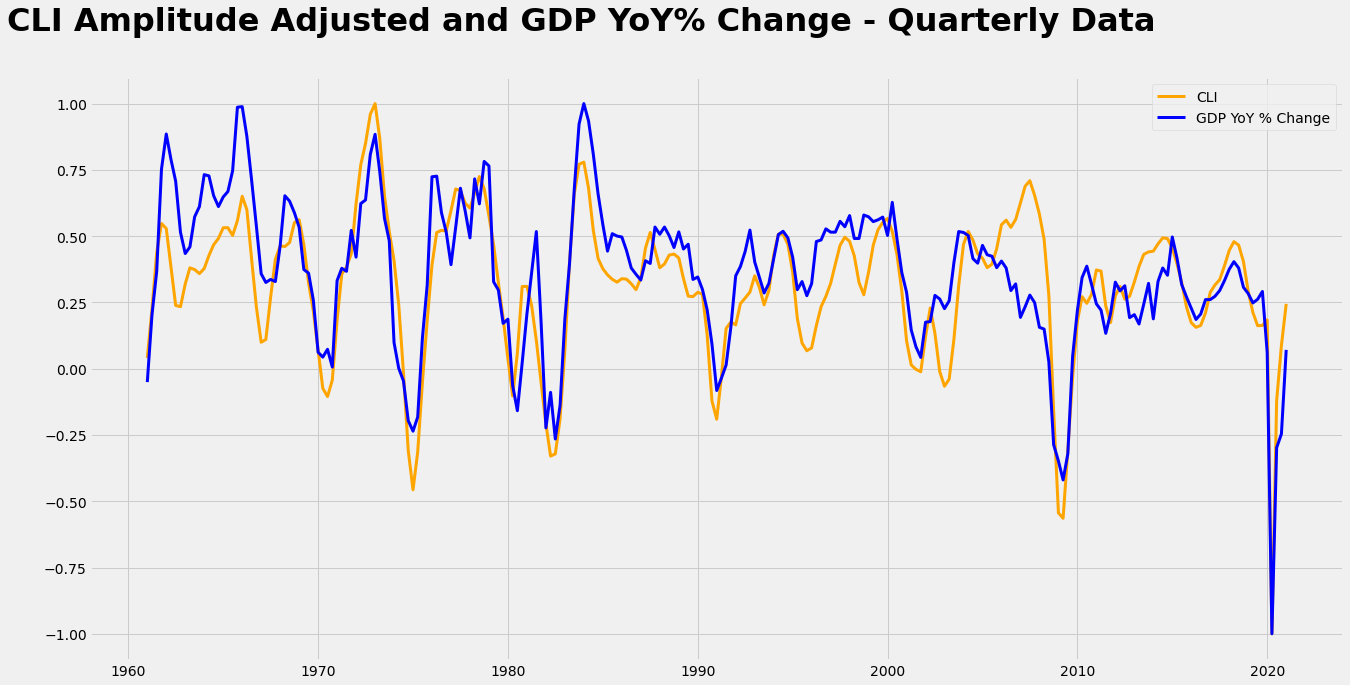

In [14]:
"""Plotting line graphs """
# Plot style
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20,10)) # chart size 2:1

# Sets Title of Plot
ax.set_title("CLI Amplitude Adjusted and GDP YoY% Change - Quarterly Data", fontsize=32, fontweight='bold', x=.392, y=1.07)

# Lineplot of CLI
plt.plot(normalized_df.index, normalized_df.cli, color='orange', linewidth=3, label="CLI")
# Lineplot of GDP YoY % Change
plt.plot(normalized_df.index, normalized_df['gdp_%yoy'], color='blue', linewidth=3, label = "GDP YoY % Change")

# Adds a legened
plt.legend(loc="upper right")

# Saving image as a .png file
plt.savefig('../graphs/GDP_CLI_lineplot.png', transparent=False, dpi=150)

plt.show()

In [15]:
# Looking at the correlation between the two features - CLI and GDP YoY % Change
# To view the correlation table = normalized_df.corr()

# Unpacking correlation, p-value = scipy.stats.pearsonr()
correlation, pvalue = scipy.stats.pearsonr(normalized_df['gdp_%yoy'], normalized_df['cli'])
# Printing the Pearson's Correlation and the p-value(statistical significance)
print(f'Correlation: {correlation}')
print(f'p-value: {pvalue}')

Correlation: 0.8122290857052571
p-value: 7.190068631166001e-58


In [16]:
# Import the estimator class - Linear Regression
from sklearn.linear_model import LinearRegression

# Instantiate the class (with default parameters)
model = LinearRegression()
model

LinearRegression()

In [17]:
# Create the 2-D features matrix
X = normalized_df['cli']
# Now making it 2-D, previously 1-D
X_cli_2d = X[:, np.newaxis]

# Turning GDP column into an array to plot
y_gdp = normalized_df['gdp_%yoy']
# Checking the shape of the feature matrix - CLI 
X_cli_2d.shape

(241, 1)

In [18]:
# Fit the Linear Regression model
model.fit(X_cli_2d, y_gdp)

LinearRegression()

In [19]:
# Slope (also called the model coefficient) / rounding to 4 decimals
print(f'model coefficient(slope): {model.coef_[0].round(4)}')

# Intercept / rounding to 4 decimals
print(f'y-intercept(constant): {model.intercept_.round(4)}')

# In equation form
print(f'\nGDP yoy% change = {model.coef_[0]} x (CLI) + {model.intercept_}')

model coefficient(slope): 0.8374
y-intercept(constant): 0.0958

GDP yoy% change = 0.8374109799365542 x (CLI) + 0.09582487082072383


In [20]:
# Generate the line from the model coefficients
x_line = np.linspace(-1, 1)
# x_line = np.linspace(170,240)
y_line = model.coef_ * x_line + model.intercept_

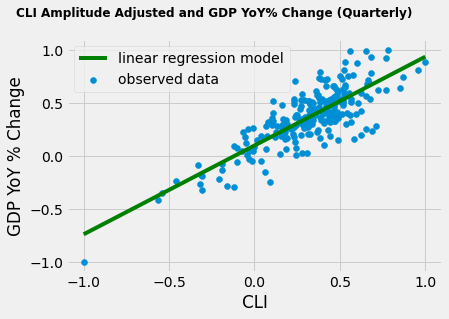

Line Equation: y = mx + b
GDP YoY% Change = (0.8374109799365542 x CLI) + 0.09582487082072383


In [21]:
"""Plotting the Linear Regression"""
# Create the figure and axes objects
fig, ax = plt.subplots(1)
# Set Title
ax.set_title("CLI Amplitude Adjusted and GDP YoY% Change (Quarterly)", fontsize=12, fontweight='bold', x=.392, y=1.07)
# Scatter plot
ax.scatter(x = X_cli_2d, y = y_gdp, label="observed data")
# Plotting regression line
ax.plot(x_line, y_line, color='g', label="linear regression model")
# Setting x and y -axis labels
ax.set_xlabel('CLI')
ax.set_ylabel('GDP YoY % Change')

# Creates Legend for linear regression and observed data
ax.legend(loc="upper left")

# Saving image as a .png file
plt.savefig('../graphs/GDP_CLI.png', transparent=False, dpi=150)
plt.show()

# In equation form
print("Line Equation: y = mx + b")
print(f'GDP YoY% Change = ({model.coef_[0]} x CLI) + {model.intercept_}')

## Saving dataset and TODO:

In [22]:
# Saving gdp and cli as .csv
pd.DataFrame.to_csv(gdp, "../datasets/gdp.csv")
pd.DataFrame.to_csv(cli, "../datasets/cli.csv")

# # Importing cli.csv dataset - Amplitude Adjusted (A Leading indicator for U.S. GDP)
# cli = pd.read_csv("datasets/cli.csv")
# cli = cli.set_index("Date")
# # Importing gdp.csv dataset - U.S. GDP (Seasonally adjusted)
# gdp = pd.read_csv("datasets/gdp.csv")
# gdp = gdp.set_index("Date")

In [23]:
# Analyze CLI (Monthly)
# TODO: Calculate the rate of change of the CLI using monthly data
# TODO: DO the same to headline CPI monthly data

# Retrieving monthly CLI and ISM-PMI data
# Pulling data from Quandl API 

# API Key
quandl.ApiConfig.api_key='1mEBe1BeVaAExprr7akA'
# Reading in the dataset from Quandl API - ISM_PMI (Monthly)
df_ism = pd.read_csv('https://www.quandl.com/api/v3/datasets/ISM/MAN_PMI.csv?api_key=1mEBe1BeVaAExprr7akA', index_col=['Date'])
# Reversing the dataframe 
ismpmi = df_ism.iloc[::-1]
# Changing index to datetime in `ismpmi` DataFrame
ismpmi.index = pd.to_datetime(ismpmi.index)
# Changing column name
ismpmi.columns = ['pmi']

In [24]:
ismpmi.tail()

,pmi
Date,
2020-12-01,60.5
2021-01-01,58.7
2021-02-01,60.8
2021-03-01,64.7
2021-04-01,60.7


In [25]:
# Making the `pmi` DataFrame start at the same date as `cli_monthly` DataFrame
pmi = ismpmi[84:].copy()

In [26]:
# Joining `pmi` and `cli_monthly` and keeping the NaN for the last date (2020-04-01)
pmi_cli = pmi.join(cli_monthly)

In [27]:
pmi_cli.tail()

,pmi,cli
Date,,
2020-12-01,60.5,99.23566
2021-01-01,58.7,99.52099
2021-02-01,60.8,99.83073
2021-03-01,64.7,100.15090
2021-04-01,60.7,NaN


In [28]:
# Initializing MinMaxScaler using a range of -1 to 1 because data needs to oscilate around 0
scaler = MinMaxScaler(feature_range=(-1,1))
# Applying scaler to data
sc_gdp_cli = scaler.fit_transform(pmi_cli)

In [29]:
# Converting the array back to a DataFrame and using the same column headers and index header
normalized_pmi_cli = pd.DataFrame(sc_gdp_cli, index=pmi_cli.index, columns=pmi_cli.columns)
# Rounding the DataFrame to 3 decimal places
normalized_pmi_cli.round(3)

# Drop NaNs
normalized_pmi_cli.dropna(inplace=True)

In [30]:
# Looking at the correlation between the two features - CLI and GDP YoY % Change

# Unpacking correlation, p-value = scipy.stats.pearsonr()
correlation, pvalue = scipy.stats.pearsonr(normalized_pmi_cli['pmi'], normalized_pmi_cli['cli'])
# Printing the Pearson's Correlation and the p-value(statistical significance)
print(f'Correlation: {correlation}')
print(f'p-value: {pvalue}')

Correlation: 0.7979549988851626
p-value: 1.5130516546944038e-176


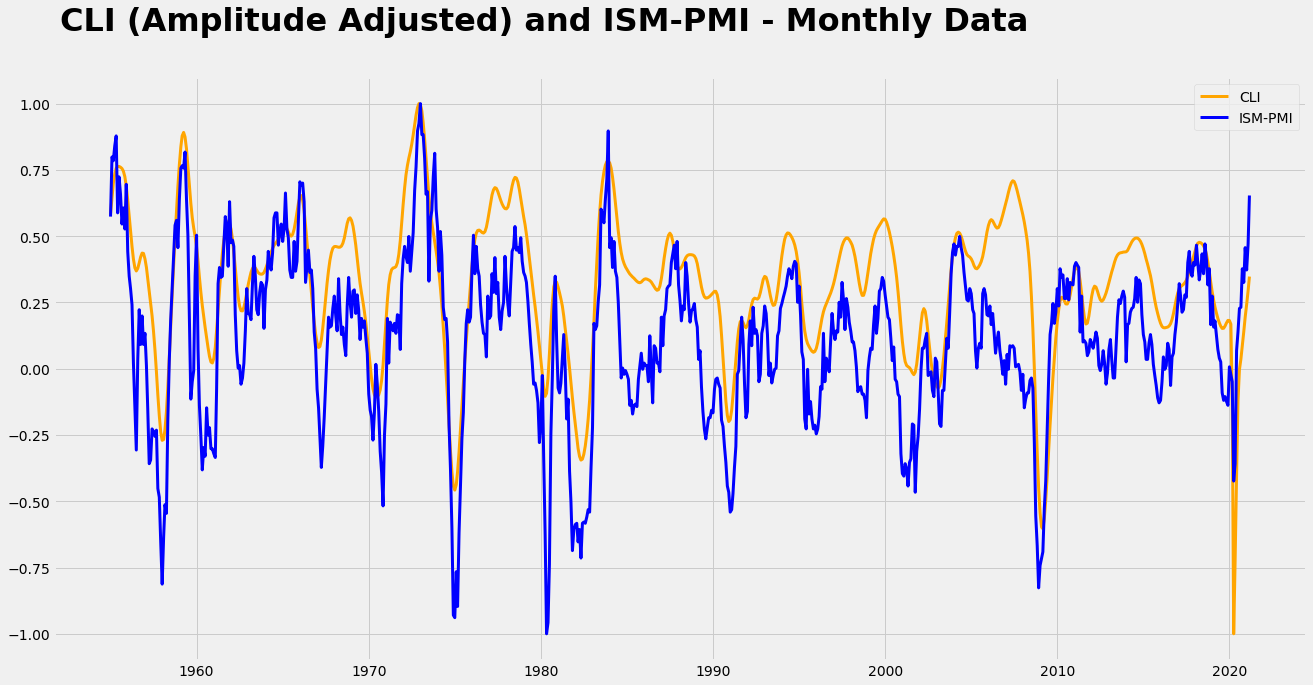

In [31]:
"""Plotting line graphs """
# Plot style
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20,10)) # chart size 2:1

# Sets Title of Plot
ax.set_title("CLI (Amplitude Adjusted) and ISM-PMI - Monthly Data", fontsize=32, fontweight='bold', x=.392, y=1.07)

# Lineplot of CLI
plt.plot(normalized_pmi_cli.index, normalized_pmi_cli['cli'], color='orange', linewidth=3, label="CLI")
# Lineplot of GDP YoY % Change
plt.plot(normalized_pmi_cli.index, normalized_pmi_cli['pmi'], color='blue', linewidth=3, label = "ISM-PMI")

# Adds a legened
plt.legend(loc="upper right")

# Saving image as a .png file
plt.savefig('../graphs/PMI_CLI_lineplot.png', transparent=False, dpi=150)

plt.show()

In [32]:
normalized_pmi_cli.columns

Index(['pmi', 'cli'], dtype='object')

In [33]:
# Instantiate the class (with default parameters)
model2 = LinearRegression()

# Create the 2-D features matrix
X = normalized_pmi_cli['cli']
# Now making it 2-D, previously 1-D
X_cli2_2d = X[:, np.newaxis]

# Turning GDP column into an array to plot
y_pmi = normalized_pmi_cli['pmi']
# Checking the shape of the feature matrix - CLI 
X_cli2_2d.shape

(795, 1)

In [34]:
# Fit the Linear Regression model
model2.fit(X_cli2_2d, y_pmi)

# Slope (also called the model coefficient) / rounding to 4 decimals
print(f'model coefficient(slope): {model2.coef_[0].round(4)}')

# Intercept / rounding to 4 decimals
print(f'y-intercept(constant): {model2.intercept_.round(4)}')

# In equation form
print(f'\nGDP yoy% change = {model2.coef_[0]} x (CLI) + {model2.intercept_}')

model coefficient(slope): 0.9441
y-intercept(constant): -0.191

GDP yoy% change = 0.9441492528992917 x (CLI) + -0.1910499953872601


In [35]:
# Generate the line from the model coefficients
x_line2 = np.linspace(-1, 1)
# x_line = np.linspace(170,240)
y_line2 = model2.coef_ * x_line + model2.intercept_

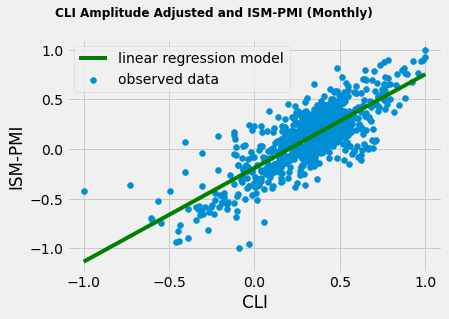

Line Equation: y = mx + b
ISM-PMI = (0.9441492528992917 x CLI) + -0.1910499953872601


In [37]:
"""Plotting the Linear Regression"""
# Create the figure and axes objects
fig, ax = plt.subplots(1)
# Set Title
ax.set_title("CLI Amplitude Adjusted and ISM-PMI (Monthly)", fontsize=12, fontweight='bold', x=.392, y=1.07)
# Scatter plot
ax.scatter(x = X_cli2_2d, y = y_pmi, label="observed data")
# Plotting regression line
ax.plot(x_line2, y_line2, color='g', label="linear regression model")
# Setting x and y -axis labels
ax.set_xlabel('CLI')
ax.set_ylabel('ISM-PMI')

# Creates Legend for linear regression and observed data
ax.legend(loc="upper left")

# Saving image as a .png file
plt.savefig('../graphs/PMI_CLI.png', transparent=False, dpi=150)
plt.show()

# In equation form
print("Line Equation: y = mx + b")
print(f'ISM-PMI = ({model2.coef_[0]} x CLI) + {model2.intercept_}')